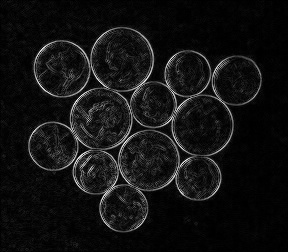

Gradient Enhanced Image


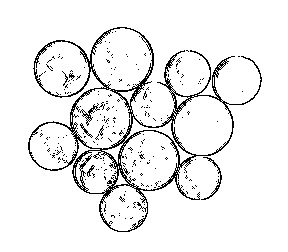

Thresholded Image


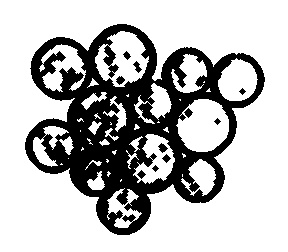

Morphological Erosion
Error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imencode'
> Overload resolution failed:
>  - img data type = bool is not supported
>  - Expected Ptr<cv::UMat> for argument 'img'



In [40]:
import cv2
import numpy as np
from IPython.display import Image, display
from skimage.morphology import skeletonize

def show_image(img, title="Image"):
    if img is None:
        raise ValueError("Image is empty")
    _, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))
    print(title)

def object_detection(img_path, kernel_size=(15, 15), distance_scale=0.5, debug=False):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image at path '{img_path}' could not be loaded.")
    
    original = img.copy()  # Save original for overlaying results later
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=1)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=1)
    gradient = cv2.addWeighted(np.abs(grad_x), 0.5, np.abs(grad_y), 0.5, 0).astype(np.uint8)

    _, thresh = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones(kernel_size, np.uint8)
    eriosion_kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)  # Ensure kernel is uint8
    erosion = cv2.erode(thresh, eriosion_kernel, iterations=3)
    skeletonized = skeletonize(erosion)
    dilation = cv2.dilate(erosion, eriosion_kernel, iterations=3)
    opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel, iterations=3)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, distance_scale * dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)

    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)

    labels = np.unique(markers)
    objects = []
    for label in labels:
        if label <= 1:  # Skip background and border markers
            continue
        mask = np.zeros(gray.shape, dtype=np.uint8)
        mask[markers == label] = 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            objects.append(contours[0])

    # Draw detected objects
    img = cv2.drawContours(original, objects, -1, (0, 255, 0), thickness=2)

    # Debug visualization
    if debug:
        show_image(gradient, "Gradient Enhanced Image")
        show_image(thresh, "Thresholded Image")
        show_image(erosion, "Morphological Erosion")
        show_image(skeletonized, "skeletonized Image")
        show_image(dilation, "Morphological Dilation")


        show_image(opening, "Morphological Opening")
        show_image(dist_transform.astype(np.uint8), "Distance Transform")
        show_image(sure_fg, "Sure Foreground")

    return img

try:
    result = object_detection("Coins.jpg", kernel_size=(7, 7), distance_scale=0.4, debug=False)
    show_image(result, "Final Detected Objects")
except Exception as e:
    print(f"Error: {e}")


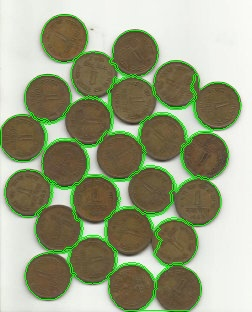

Final Detected Objects


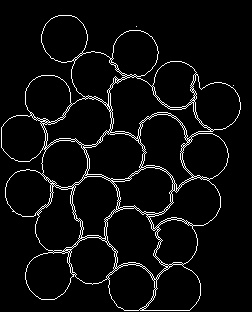

Binary Image


In [19]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

def show_image(img, title="Image"):
    """
    Display an image in Jupyter Notebook.
    """
    if img is None:
        raise ValueError("Image is empty")
    _, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))
    print(title)

def object_detection(img_path, kernel_size=(15, 15), distance_scale=0.625, debug=False):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image at path '{img_path}' could not be loaded.")
    
    original = img.copy()  # Save original for overlaying results later
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, distance_scale * dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)

    # Identify unknown regions
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(img, markers)

    # Draw contours and bounding boxes
    labels = np.unique(markers)
    objects = []
    for label in labels:
        if label <= 1:  # Skip background and border markers
            continue
        mask = np.zeros(gray.shape, dtype=np.uint8)
        mask[markers == label] = 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            objects.append(contours[0])

    # Draw detected objects
    img = cv2.drawContours(original, objects, -1, (0, 255, 0), thickness=1)

    # Binaraize the image for filling
    binary = np.zeros_like(img[:,:,0])

    for (x, y, _) in np.argwhere(img==(0,255,0)):
        binary[x, y] = 255



    # Debug visualization
    if debug:
        show_image(thresh, "Thresholded Image")
        show_image(opening, "Morphological Opening")
        show_image(dist_transform.astype(np.uint8), "Distance Transform")
        show_image(sure_fg, "Sure Foreground")
    return [img, binary]

# Usage example
result,binary = object_detection("input.jpg", debug = False)
show_image(result, "Final Detected Objects")
show_image(binary, "Binary Image")
